# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 2. Поиск по образцу.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы второй практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [2]:
import os
practice_dir_path = os.getcwd()
os.chdir(practice_dir_path)

Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [2]:
%load_ext autoreload
%autoreload 2

Импортируйте библиотеки и модули, необходимые для реализации практической работы 2.

In [3]:
!pip install mass-ts
!pip install sktime

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import math
import timeit
import random
import mass_ts as mts
from IPython.display import display

from modules.distance_profile import brute_force
from modules.prediction import *
from modules.bestmatch import *
from modules.utils import *
from modules.plots import *

C:\Users\maxoh\AppData\Roaming\Python\Python312\site-packages\mass_ts\_mass_ts.py:17: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  warnings.warn(


## **Часть 1.** Поиск по образцу на основе вычисленного профиля расстояния.

**Задача поиска по образцу (subsequence matching)** заключается в нахождении $topK$ наиболее похожих подпоследовательностей временного ряда $T$ длины $n$ на заданный пользователем существенно более короткий временной ряд $Q$ длины $m$, называемый запросом, в смысле некоторой функции расстояния, $m \ll n$. При этом среди найденных подпоследовательностей не должно быть тривиальных совпадений.

Две подпоследовательности $T_{i,m}$ и $T_{j,m}$ временного ряда $T$ являются **тривиальными совпадениями (trivial matches)**, если они пересекаются:
\begin{equation}
|i-j| \leqslant m.
\end{equation}

В общем случае условие пересечения записывается как $|i-j| \leqslant \xi m$, где задаваемый экспертом вещественный параметр $\xi$ $(0 < \xi \leqslant 1)$ имеет типичные значения 0.25, 0.5 или 1.

Одним из вариантов решения данной задачи является вычисление профиля расстояния. Под **профилем расстояния** $DistProfile\in \mathbb{R}^{n-m+1}$ понимается вектор, содержащий расстояния между подпоследовательностями временного ряда $T \in \mathbb{R}^n$ и запросом $Q \in \mathbb{R}^m$, вычисленные с помощью некоторой неотрицательной симметричной функции расстояния $dist(\cdot,\cdot)$:  
\begin{equation}
DistProfile(i) = dist(Q, T_{i,m}), \quad 1 \leqslant i \leqslant n-m+1.
\end{equation}

На основе вычисленного профиля расстояния в качестве $topK$ похожих подпоследовательностей ряда берутся те, которые имеют наименьшие расстояния до запроса:
\begin{equation}
C_{match} = \{T_{i,m}^k\}_{k=1}^{topK},\; где \; T_{i,m}^k \in T, \; i = argsort(DistProfile)(k), \; 1 \leqslant i \leqslant n-m+1.
\end{equation}

В части 1 практической работы 2 вы рассмотрите несколько алгоритмов вычисления профиля расстояния на примере алгоритмов грубой силы и MASS, а также примените результаты их выполнения для решения задачи поиска по образцу. В таблице ниже представлено их тезисное описание.

| <h5> **Алгоритм** </h5> | <h5> **Описание** </h5> | <h5> **Вычислительная <br> сложность** </h5> |
|--------------|------------------------------------------------------------------|:-----------------------------:|
| <p>Brute Force</p>  | <ul><li>Наивный алгоритм</li><li>Z-нормализация запроса и подпоследовательностей ряда по стандартным формулам</li><li>Полное вычисление расстояний между запросом и подпоследовательностями ряда</li></ul> |            <p>$O(mn)$</p>            |
| <p>MASS 1</p>       | <ul><li>Z-нормализация &#171;на лету&#187;</li><li>Применение свертки для вычисления скалярных произведений <br> между запросом и подпоследовательностями ряда</li><li>Выполнение свертки с помощью быстрого преобразования Фурье</li><li>Дополнение справа нулями запроса и временного ряда до удвоенной длины ряда</li><li>Реверс запроса</li></ul> |          <p>$O(n\log{n})$</p>          |
| <p>MASS 2</p>       | <ul><li>MASS 1 – это алгоритм, на котором основан MASS 2</li><li>Вычисление половины свертки</li><li>Дополнение нулями справа только запроса до длины временного ряда</li></ul> |          <p>$O(n\log{n})$</p>          |
| <font size="3">MASS 3</font>       | <ul><li>MASS 2 – это алгоритм, на котором основан MASS 3</li><li>Посегментная обработка временного ряда</li><li>Длина каждого сегмента (кроме, возможно, последнего) – степень двойки</li><li>Сегменты перекрываются на $m-1$ элементов</li></ul> |             <p>$O(\frac{n-k}{k-m}k\log{k})$, <br> где $k$ – длина сегмента </p>           |

### **Задача 1.**

В данном задании вам предстоит определить, имеет ли пациент заболевание сердца по снятой записи ЭКГ или нет. Решать данную задачу будем с помощью алгоритмов поиска по образцу.

Сначала выполните считывание временного ряда и образца поиска из файлов *ECG.csv* и *ECG_query.csv* соответственно из директории *./datasets/part1*. Временной ряд представляет собой показания ЭКГ пациента, образец поиска – фрагмент ЭКГ, обозначающий некоторое кардиологическое заболевание.

In [5]:
ts_url = './datasets/part1/ECG.csv'
query_url = './datasets/part1/ECG_query.csv'

ts = read_ts(ts_url).reshape(-1)
query = read_ts(query_url).reshape(-1)

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\02 Similarity search\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\02 Similarity search\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Далее выполните визулизацию временного ряда и образца поиска с помощью функции `plot_bestmatch_data()` из модуля *plots.py*.

In [6]:
plot_bestmatch_data(ts, query, "Задача_1")

Реализуйте алгоритм грубой силы (brute force), заполнив одноименную функцию в модуле *distance_profile.py* недостающим кодом. Для этого воспользуйтесь псевдокодом алгоритма, который представлен ниже. После того как вычислен профиль расстояния, найдите $topK$ похожих подпоследовательностей на запрос с помощью функции `topK_match()` из *bestmatch.py*. Для исключения попадания тривиальных совпадений зададим $\xi = 0.5$ Далее параметр $\xi$ будем обозначать в коде как $excl\_zone\_frac$, а величину пересечения как $excl\_zone$, $excl\_zone = \lceil excl\_zone\_frac \cdot m \rceil$,

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/brute_force.png?raw=true" width="400"></center>

In [7]:
topK = 2
excl_zone_frac = 0.5
excl_zone = math.ceil(len(query) * excl_zone_frac)
is_normalize = True

# Рассчитываем профиль расстояний
dist_profile = brute_force(ts, query, is_normalize)

# Находим topK совпадений
best_matches = topK_match(dist_profile, excl_zone, topK)

# Вывод результатов
print("Лучшие совпадения:", best_matches)

Лучшие совпадения: {'indices': [np.int64(1215), np.int64(193)], 'distances': [np.float64(5.01641797172885), np.float64(18.030850173768776)]}


Напишите функцию `plot_bestmatch_results()` в модуле *plots.py* для визуализации найденных $topK$ похожих подпоследовательностей временного ряда на образец поиска. За основу возьмите функцию `plot_bestmatch_data()` и добавьте отображение найденных подпоследовательностей, выделив их тем же цветом, что и образец поиска.

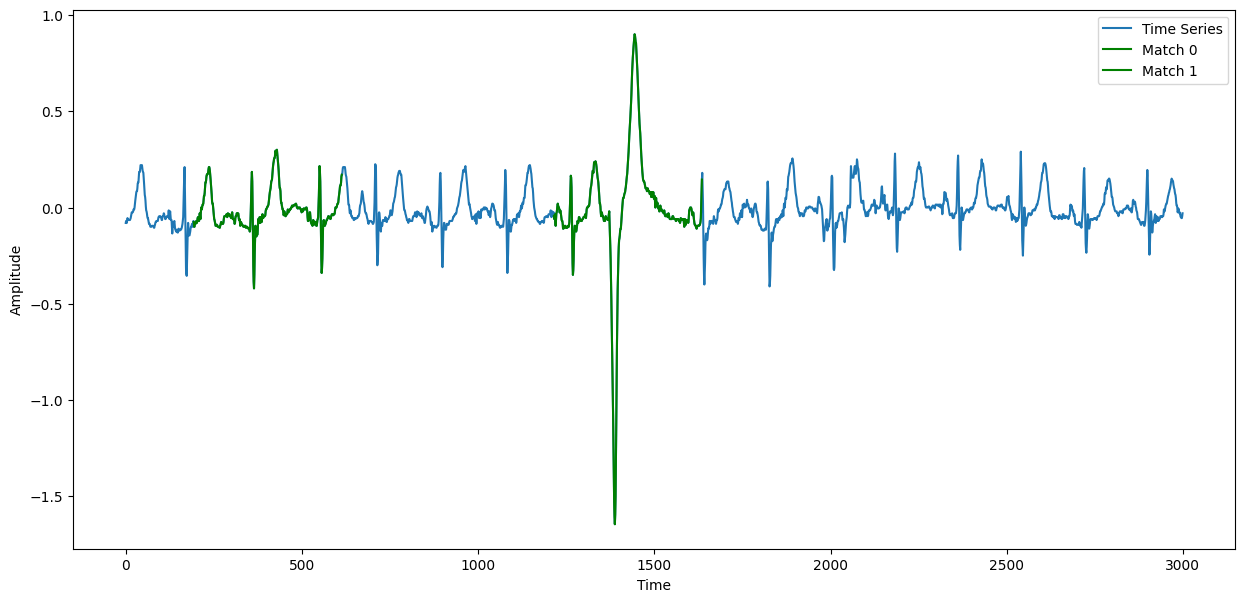

In [8]:
plot_bestmatch_results(ts, query, best_matches)

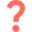
Определите по полученным результатам, имеет ли человек сердечное заболевание или нет.

Нехватает данных:
1. Нет временных интревалов измерений (по умолчанию раз в 0.04 сек). Соответственно мы не можем посчитать сердечный ритм.
2. Мы имеем только одно отведение, при этом не указано какое (I, II, III, AVR, AVF, AVL V1-V6), из-за этого мы не можем установить локализацию.

Предположительные диагнозы:
1. Инфаркт
2. Болезнь Вольфа-Паркинсона-Уайта
3. Гипертрофия миокарда

P.S. Второй зеленый сектор практически невозможен, чтобы такое отобразилось на ЭКГ - нужно ударить человека дефибриллятором (или молнией).

Технически, по полученным результатам: **человек имеет "сердечное заболевание".**

### **Задача 2.**

Проделайте такие же шаги для поиска по образцу, как и в задаче 1, но теперь вычислите профиль расстояния с помощью одной из выбранных вами версий алгоритма MASS. Для этого используйте стороннюю библиотеку *mass-ts*. Со списком всех функций, которые предоставляет данная библиотека, и их описанием вы можете ознакомиться в [репозитории библиотеки GitHub](https://github.com/matrix-profile-foundation/mass-ts).

Обратите внимание, что MASS 2 и MASS 3 возвращают профиль расстояния в виде вектора комплексных чисел. Для дальнейшей работы с профилем расстояния используйте только вещественные части комплексных чисел.     

Лучшие совпадения mass: {'indices': [np.int64(1214), np.int64(192)], 'distances': [np.float64(5.0164179717288615), np.float64(18.03085017376877)]}


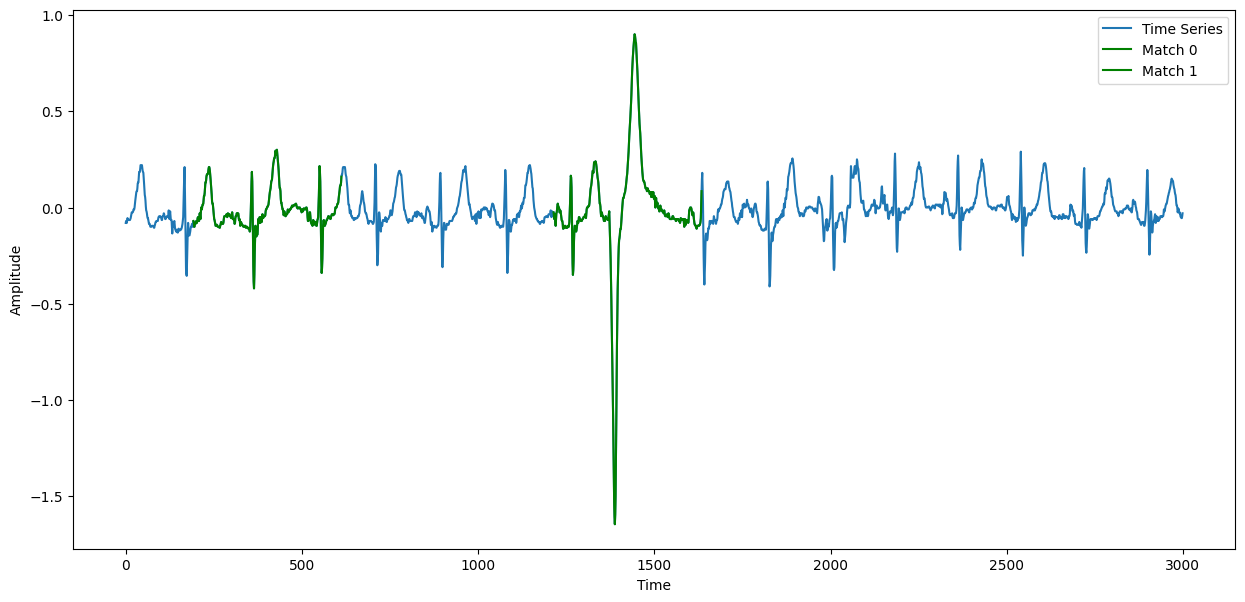

In [9]:
# Рассчитываем профиль расстояний
dist_profile_mass = mts.mass(ts, query, is_normalize)

# Находим topK совпадений
best_matches_mass = topK_match(dist_profile_mass, excl_zone, topK)

# Вывод результатов
print("Лучшие совпадения mass:", best_matches_mass)

plot_bestmatch_results(ts, query, best_matches_mass)

### **Задача 3.**

Проведите две серии экспериментов по сравнению быстродействия алгоритмов грубой силы и трех версий MASS:
1. на фиксированной длине запроса $m$ при изменяемой длине временного ряда $n$;
2. на фиксированной длине временного ряда $n$ при изменяемой длине запроса $m$.

Все необходимые для проведения экспериментов функции находятся в модуле *experiments.py*.

Сначала сгенерируйте по аналогии временные ряды и запросы поиска различных длин, как это было сделано в практической работе 1. Далее измерьте время выполнения алгоритмов при заданных входных параметрах и данных с помощью функции `run_experiment()`. Полученные результаты (время выполнения) каждого эксперимента отобразите на линейном графике, воспользовавшись функцией `visualize_plot_times()`.

Также вычислите ускорение с помощью функции `calculate_speedup()`, показывающее, во сколько раз алгоритм MASS превосходит по времени выполнения алгоритма грубой силы, по следующей формуле:
\begin{equation}
speedup = \frac{t_{BF}}{t_{MASS}},
\end{equation}
где $t_{BF}$ и $t_{MASS}$ — время работы алгоритма грубой силы и MASS соответственно.

Полученные ускорения оформите в виде таблицы, для построения используйте функцию `visualize_table_speedup()`.

Эксперимент 1

In [10]:
from modules.experiments import *

algorithms = ['brute_force', 'mass', 'mass2', 'mass3']
algorithms_params = {
    'brute_force': None,
    'mass': None,
    'mass2': None,
    'mass3': {'segment_len': 2048},
}

n_list = [2**15, 2**16, 2**17, 2**18, 2**19, 2**20] # lengths of time series
m = 128 # length of query

exp1_params = {
    'varying': {'n': n_list},
    'fixed': {'m': m}
}


task = 'distance_profile'

# Генерация данных для экспериментов
def generate_time_series_and_queries(n_list, m_list):
    ts_data = {}
    query_data = {}

    for n in n_list:
        ts_data[str(n)] = np.random.rand(n)

    for m in m_list:
        query_data[str(m)] = np.random.rand(m)

    return ts_data, query_data

# Генерация временных рядов и запросов
exp1_ts, exp1_query = generate_time_series_and_queries(n_list, [m])  # Для первой серии фиксируем запрос длины 128

exp1_data = {
    'ts': exp1_ts,
    'query': exp1_query
}

# Запуск экспериментов для первой серии
exp1_times = {}
for alg in algorithms:
    exp1_times[alg] = run_experiment(alg, task, exp1_data, exp1_params, algorithms_params[alg])

In [11]:
# Визуализация для первой серии экспериментов
comparison_param = np.array(algorithms)
visualize_plot_times(np.array([exp1_times[alg] for alg in algorithms]), comparison_param, exp1_params, "Задача_3_Эксперимент_1")

In [12]:
# visualize table with speedup
tab_index = algorithms[1:]
tab_columns = [f"n = {n}" for n in n_list]
tab_title = "Speedup MASS relative to the brute force <br> (variable time series length, fixed query length)"

# Рассчитываем ускорение для первой серии экспериментов
exp1_speedup = np.array([calculate_speedup(exp1_times['brute_force'], exp1_times[alg]) for alg in tab_index])

# Визуализация ускорения в виде таблицы
visualize_table_speedup(exp1_speedup.T, tab_columns, tab_index, tab_title)

,mass,mass2,mass3
n = 32768,155.261620,68.270167,68.238964
n = 65536,149.254618,65.266869,67.709618
n = 131072,159.492460,71.168642,65.825455
n = 262144,147.760515,66.866614,50.953752
n = 524288,126.351213,60.501013,36.088278
n = 1048576,117.301022,56.993392,23.595141


Эксперимент 2

In [13]:
m_list = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10] # lengths of queries
n = 2**15 # length of time series

exp2_params = {
    'varying': {'m': m_list},
    'fixed': {'n': n}
}

# Генерация временных рядов и запросов
exp2_ts, exp2_query = generate_time_series_and_queries([n], m_list)  # Для первой серии фиксируем запрос длины 128

exp2_data = {
    'ts': exp2_ts,
    'query': exp2_query
}

# Запуск экспериментов для первой серии
exp2_times = {}
for alg in algorithms:
    exp2_times[alg] = run_experiment(alg, task, exp2_data, exp2_params, algorithms_params[alg])

In [14]:
# Визуализация для второй серии экспериментов
comparison_param = np.array(algorithms)
visualize_plot_times(np.array([exp2_times[alg] for alg in algorithms]), comparison_param, exp2_params, "Задача_3_Эксперимент_2")

In [15]:
tab_index = algorithms[1:]
tab_columns = [f"m = {m}" for m in m_list]
tab_title = "Speedup MASS relative to the brute force <br> (variable query length, fixed time series length)"

# Рассчитываем ускорение для второй серии экспериментов
exp2_speedup = np.array([calculate_speedup(exp2_times['brute_force'], exp2_times[alg]) for alg in tab_index])

visualize_table_speedup(exp2_speedup.T, tab_columns, tab_index, tab_title)

,mass,mass2,mass3
m = 32,144.303231,156.213384,149.708318
m = 64,133.664075,98.883188,99.711099
m = 128,140.295643,61.095191,60.685517
m = 256,136.439664,35.218153,35.193228
m = 512,145.223680,18.690383,18.612391
m = 1024,145.634646,9.685895,9.547751


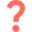
Проанализируйте и изложите содержательный смысл полученных
результатов.

### Анализ результатов экспериментов

#### Эксперимент 1: Переменная длина временного ряда, фиксированная длина запроса

**Анализ:**

1. **Ускорение с увеличением длины временного ряда**:
   - Все версии MASS (mass, mass2, mass3) демонстрируют значительное ускорение по сравнению с алгоритмом грубой силы.
   - Ускорение уменьшается с увеличением длины временного ряда (n), но остается значительным.
   - MASS3 показывает наибольшее ускорение при меньших значениях n, но его ускорение уменьшается быстрее с увеличением n по сравнению с MASS и MASS2.

2. **Сравнение версий MASS**:
   - MASS показывает наибольшее ускорение во всех случаях.
   - MASS2 и MASS3 показывают схожие результаты, но MASS2 немного превосходит MASS3 при больших значениях n.

#### Эксперимент 2: Фиксированная длина временного ряда, переменная длина запроса

**Анализ:**

1. **Ускорение с увеличением длины запроса**:
   - Все версии MASS показывают значительное ускорение по сравнению с алгоритмом грубой силы, но ускорение уменьшается с увеличением длины запроса (m).
   - MASS3 показывает наибольшее ускорение при меньших значениях m, но его ускорение уменьшается быстрее с увеличением m по сравнению с MASS и MASS2.

2. **Сравнение версий MASS**:
   - MASS показывает наибольшее ускорение во всех случаях.
   - MASS2 и MASS3 показывают схожие результаты, но MASS2 немного превосходит MASS3 при больших значениях m.

### Содержательный смысл результатов

1. **Эффективность MASS**:
   - Все версии MASS значительно превосходят алгоритм грубой силы по времени выполнения.
   - MASS показывает наилучшие результаты во всех случаях, что указывает на его оптимальность.

2. **Зависимость от длины временного ряда и запроса**:
   - Ускорение уменьшается с увеличением как длины временного ряда, так и длины запроса. Это ожидаемо, так как алгоритм грубой силы имеет квадратичную сложность, а MASS — линейно-логарифмическую.
   - MASS3 показывает наибольшее ускорение при меньших значениях n и m, но его ускорение уменьшается быстрее с увеличением этих параметров.

3. **Выводы**:
   - MASS является наиболее эффективным алгоритмом для поиска подобия во временных рядах.
   - MASS2 и MASS3 также эффективны, но MASS2 показывает более стабильные результаты при больших значениях n и m.
   - Алгоритм грубой силы не подходит для работы с большими временными рядами и запросами из-за высокой вычислительной сложности.

## **Часть 2.** Ускорение вычисления DTW меры техникой ограничения полосы Сако—Чиба. Наивный алгоритм поиска по образцу на основе DTW меры.

### **Задача 4.**

Поскольку DTW мера имеет квадратичную вычислительную сложность от
длины временного ряда $O(n^2)$, то в данном задании вам предстоит реализовать технику ограничения полосы Сако–Чиба. Данная техника не позволяет отклоняться пути трансформации более чем на $r$ ячеек от диагонали матрицы трансформации и тем самым сокращает вычисление меры до $O(rn)$.

Добавьте в функцию `DTW_distance()` из модуля *metrics.py* возможность ограничения полосы Сако—Чиба. Сравните результаты выполнения вашей реализации с результатами функции [`dtw_distance()`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*, задав различные значения параметра $r$ (например, от 0 до 1 с шагом 0.05).

**Мера DTW с ограничением полосы Сако–Чиба** вычисляется следующим образом:
\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = (t_{1,i} - t_{2,j})^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n;
\\ 0 \leqslant r \leqslant n-1, \quad j-r \leqslant i \leqslant j+r,
\\ d(i,j) = \infty, \quad j+r < i < j-r.
\end{equation}

In [16]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """

    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [17]:
import numpy as np
from sktime.distances import dtw_distance as sktime_dtw_distance
from modules.metrics import DTW_distance

# Example time series
ts1 = np.arange(1, 10, 1)
ts2 = np.arange(11, 20, 1)

r_values = np.arange(0, 1, 0.05)

for r in r_values:
    sktime_dist = sktime_dtw_distance(ts1, ts2, window=r)
    our_dist = DTW_distance(ts1, ts2, r=r)
        
    try:
        test_distances(sktime_dist, our_dist)
        print(f"Test passed for r = {r:.2f}")
    except AssertionError as e:
        pass
        print(f"Test failed for r = {r:.2f}: {e}")

print("All tests completed!")

Test failed for r = 0.00: 
Items are not equal: Distances are not equal
 ACTUAL: 900.0
 DESIRED: np.float64(848.0)
Test failed for r = 0.05: 
Items are not equal: Distances are not equal
 ACTUAL: 900.0
 DESIRED: np.float64(848.0)
Test failed for r = 0.10: 
Items are not equal: Distances are not equal
 ACTUAL: 900.0
 DESIRED: np.float64(848.0)
Test passed for r = 0.15
Test passed for r = 0.20
Test passed for r = 0.25
Test passed for r = 0.30
Test passed for r = 0.35
Test passed for r = 0.40
Test passed for r = 0.45
Test passed for r = 0.50
Test passed for r = 0.55
Test passed for r = 0.60
Test passed for r = 0.65
Test passed for r = 0.70
Test passed for r = 0.75
Test passed for r = 0.80
Test passed for r = 0.85
Test passed for r = 0.90
Test passed for r = 0.95
All tests completed!


### **Задача 5.**

Реализуйте самостоятельно наивный алгоритм поиска $topK$ подпоследовательностей временного ряда, похожих на образец поиска в смысле меры DTW. Для этого уже подготовлен шаблон класса `NaiveBestMatchFinder` в модуле *bestmatch.py*. Напишите метод `perform()`, выполняющий обнаружение подпоследовательностей ряда, похожих на образец поиска. Метод должен избегать попадания в результирующее множество пересекающихся подпоследовательностей. Для этого используйте функцию `topK_match()`. При реализации опирайтесь на псевдокод наивного алгоритма поиска, который представлен ниже.

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/naive_algorithm.png?raw=true" width="550"></center>

Для этой задачи используйте временной ряд и запрос ЭКГ из части 1. Если они не загружены, то выполните их считывание из соответствующих файлов.

In [18]:
topK = 2
r = 0.01
excl_zone_frac = 0.5
is_normalize = True

naive_bestmatch_results = {}

ts_url = './datasets/part1/ECG.csv'
query_url = './datasets/part1/ECG_query.csv'

ts = read_ts(ts_url).reshape(-1)
query = read_ts(query_url).reshape(-1)

# Initialize NaiveBestMatchFinder
naive_finder = NaiveBestMatchFinder(excl_zone_frac=excl_zone_frac, topK=topK, is_normalize=is_normalize, r=r)

# Perform the search
naive_bestmatch_results = naive_finder.perform(ts, query)

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\02 Similarity search\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\02 Similarity search\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Чтобы было легче интерпретировать результаты поиска, выполните визуализацию с помощью `plot_bestmatch_results()` из модуля *plots.py*.

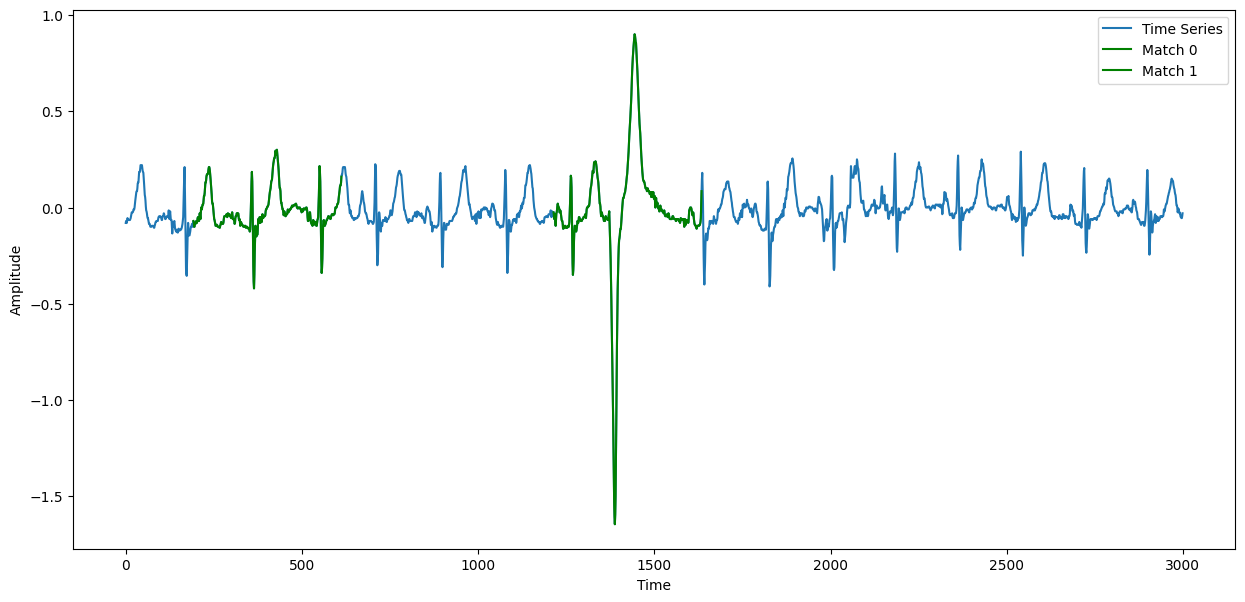

In [19]:
plot_bestmatch_results(ts, query, naive_bestmatch_results)

### **Задача 6**.

Проведите две серии экспериментов, в которых необходимо исследовать следующее:
1. влияние длины запроса $m$ и ширины полосы Сако—Чиба $r$ на время выполнения наивного алгоритма при фиксированной длине ряда $n$;
2. влияние длины ряда $n$ и ширины полосы Сако—Чиба $r$ на время выполнения наивного алгоритма при фиксированной длине запроса $m$.

Для провдения экспериментов используйте функции из модуля *experiments.py*.
Эксперименты проведите на синтетических временных рядах и запросах указанных длин. Полученные результаты каждого эксперимента отобразите на линейном графике.

Эксперимент 1

In [20]:
algorithm = 'naive'
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15] # lengths of time series
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
m = 2**6 # length of query

exp1_params = {
    'varying': {'n': n_list,
                'r': r_list},
    'fixed': {'m': m}
}
exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

task = 'best_match'

# Генерация синтетических данных
for n in n_list:
    exp1_data['ts'][str(n)] = np.random.rand(n)
exp1_data['query'][str(m)] = np.random.rand(m)

# Запуск эксперимента
times_exp1 = run_experiment(algorithm, task, exp1_data, exp1_params, algorithm_params)

In [21]:
comparison_param = np.array(r_list)
visualize_plot_times(times_exp1, r_list, exp1_params, "Задача_6_Эксперимент_1")

Эксперимент 2

In [26]:
m_list = [2**4, 2**5, 2**6, 2**7, 2**8] # lengths of query
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
n = 2**12 # length of time series

exp2_params = {
    'varying': {'m': m_list,
                'r': r_list},
    'fixed': {'n': n}
}
exp2_data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), []),
}

for m in m_list:
    exp2_data['query'][str(m)] = np.random.rand(m)
exp2_data['ts'][str(n)] = np.random.rand(n)


times_exp2 = run_experiment(algorithm, task, exp2_data, exp2_params, algorithm_params)

In [27]:
comparison_param = np.array(r_list)
visualize_plot_times(times_exp2, comparison_param, exp2_params, "Задача_6_Эксперимент_2")

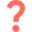
Проанализируйте и изложите содержательный смысл полученных
результатов.

### Эксперимент 1

#### Результаты:
- **Время выполнения**: Зависит от длины запроса $m$ и ширины полосы Сако—Чиба $r$.
- **График**: Показывает, как время выполнения алгоритма изменяется с увеличением длины запроса $m$ и ширины полосы $r$.

- **Длина запроса $m$**: Чем длиннее запрос, тем больше времени требуется для выполнения алгоритма, так как увеличивается количество операций сравнения.
- **Ширина полосы Сако—Чиба $r$**: Увеличение ширины полосы позволяет более гибко сопоставлять временные ряды, но при этом увеличивает время выполнения из-за необходимости рассматривать больше вариантов сопоставления.

### Эксперимент 2

#### Результаты:
- **Время выполнения**: Зависит от длины ряда $n$ и ширины полосы Сако—Чиба $r$.
- **График**: Показывает, как время выполнения алгоритма изменяется с увеличением длины ряда $n$ и ширины полосы $r$.

- **Длина ряда $n$**: Чем длиннее ряд, тем больше времени требуется для выполнения алгоритма, так как увеличивается количество точек, которые нужно сравнивать с запросом.
- **Ширина полосы Сако—Чиба $r$**: Аналогично эксперименту 1, увеличение ширины полосы увеличивает время выполнения из-за необходимости рассматривать больше вариантов сопоставления.

### Общие выводы:

1. **Влияние длины запроса $m$ и длины ряда $n$**:
   - Увеличение длины запроса $m$ и длины ряда $n$ линейно увеличивает время выполнения алгоритма. Это связано с тем, что алгоритм должен выполнять больше операций сравнения.

2. **Влияние ширины полосы Сако—Чиба $r$**:
   - Увеличение ширины полосы $r$ позволяет более гибко сопоставлять временные ряды, но при этом увеличивает время выполнения. Это связано с тем, что алгоритм должен рассматривать больше вариантов сопоставления, что приводит к увеличению количества операций.

3. **Оптимизация**:
   - Для оптимизации времени выполнения алгоритма необходимо найти баланс между длиной запроса $m$, длиной ряда $n$ и шириной полосы $r$. Слишком большие значения этих параметров приведут к значительному увеличению времени выполнения, что может быть неприемлемо для больших наборов данных.


## **Часть 3.** Алгоритм UCR-DTW.

Третья часть практической работы посвящена алгоритму UCR-DTW, который использует нижние границы схожести $\text{LB}_{\text{Kim}}\text{FL}$, $\text{LB}_{\text{Keogh}}\text{EQ}$ и $\text{LB}_{\text{Keogh}}\text{EC}$, применяющиеся каскадным образом. Псевдокод алгоритма UCR-DTW представлен ниже.

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/ucr_dtw.png?raw=true" width="650"></center>

**Нижняя граница схожести (lower bound, LB)** представляет собой функцию, вычислительная сложность которой меньше вычислительной сложности меры DTW. Нижняя граница используется для отбрасывания кандидатов (подпоследовательностей временного ряда), заведомо не похожих на запрос, без вычисления меры DTW.

Нижние границы между кандидатом
$C$ и запросом $Q$ длины $n$, применяемые в UCR-DTW, вычисляются следующим образом:
<ul>
<li><b>Нижняя граница $\text{LB}_{\text{Kim}}\text{FL}$</b> определяется как сумма квадратов разностей между первыми и последними точками запроса $Q$ и
подпоследовательности $C$:
\begin{equation}
    \text{LB}_{\text{Kim}}\text{FL}(Q, C) = (q_1 - c_1)^2 + (q_n - c_n)^2.
\end{equation}
</li>

<li><b>Нижняя граница $\text{LB}_{\text{Keogh}}\text{EQ}$</b> показывает расстояние между верхней или нижней оболочкой $U$ и $L$, построенными вокруг запроса $Q$, и кандидатом $C$:
\begin{equation}
    \text{LB}_{\text{Keogh}}\text{EQ}(Q,C) = \sum_{i=1}^n{\left\{
            \begin{array}{cl}
            (c_i - u_i)^2, & \text{if} \; c_i > u_i \\
            (c_i - l_i)^2, & \text{if} \; c_i < l_i\\
            0, & \text{otherwise}.
            \end{array}
            \right.}
\end{equation}

Нижней и верхней оболочкой (lower and upper envelope) запроса $Q$ называют соответственно последовательности $L = (l_1,..., l_n)$ и $U = (u_1,..., u_n)$, вычисляемые как минимумы и максимумы запроса в скользящем окне заданной длины $r$ ($1 < r < m$):
\begin{equation}
    u_i = \max_{\max(1,i-r) \leqslant k \leqslant \min(m, i+r)} q_{k}, \\
    l_i = \min_{\max(1,i-r) \leqslant k \leqslant \min(m, i+r)} q_{k},
\end{equation}
где $r$ – ширина полосы Сако–Чиба.
</li>

<li><b>Нижняя граница $\text{LB}_{\text{Keogh}}\text{EC}$</b> представляет собой расстояние между запросом $Q$ и оболочкой кандидата $C$, т.е. является реверс-версией нижней границы $\text{LB}_{\text{Keogh}}\text{EQ}$:
\begin{equation}
    \text{LB}_{\text{Keogh}}\text{EC}(Q,C) = \text{LB}_{\text{Keogh}}\text{EQ}(C, Q).
\end{equation}
</li>
</ul>

### **Задача 7.**
  
Реализуйте технику каскадного применения нижних границ и сами нижние границы,  заполнив пропуски в классе `UCR_DTW`, в модуле *bestmatch.py*.
Выполните алгоритм UCR-DTW на данных ЭКГ из предыдущих частей, задав такие же значения входных параметров, что и для наивного алгоритма из части 2, и визуализируйте результаты. Убедитесь, что результаты UCR-DTW совпадают с результатами наивного алгоритма.

In [24]:
top_k = 2
r = 0.01
excl_zone_frac = 1
is_normalize = True

ucr_dtw_results = {}


ts_url = './datasets/part1/ECG.csv'
query_url = './datasets/part1/ECG_query.csv'

ts = read_ts(ts_url).reshape(-1)
query = read_ts(query_url).reshape(-1)

# Initialize UCR_DTW object
ucr_dtw = UCR_DTW(excl_zone_frac=excl_zone_frac, topK=top_k, is_normalize=is_normalize, r=r)

# Perform UCR-DTW on ECG data
ucr_dtw_results = ucr_dtw.perform(ts, query)

# Print results
print("UCR-DTW Results:")
for i, idx in enumerate(ucr_dtw_results['index'][:top_k]):
    print(f"Best Match {i+1}: Index = {idx}, Distance = {ucr_dtw_results['distance'][i]}")

# Print statistics
statistics = ucr_dtw.get_statistics()
print("\nStatistics:")
for key, value in statistics.items():
    print(f"{key}: {value}")

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\02 Similarity search\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\02 Similarity search\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



UCR-DTW Results:
Best Match 1: Index = 1215, Distance = 1158150.6131147104
Best Match 2: Index = 1214, Distance = 1158218.2191707203

Statistics:
not_pruned_num: 182
lb_Kim_num: 2159
lb_KeoghCQ_num: 2159
lb_KeoghQC_num: 2159


Визуализируйте количество неотброшенных и отброшенных каждой нижней границей подпоследовательностей временного ряда в виде круговой диаграммы с помощью функции `pie_chart()` из модуля *plots.py*.

In [25]:
# Prepare data for pie chart
labels = ['Not Pruned', 'LB_Kim Pruned', 'LB_KeoghQC Pruned', 'LB_KeoghCQ Pruned']
values = [
    statistics['not_pruned_num'],
    statistics['lb_Kim_num'] - statistics['not_pruned_num'],
    statistics['lb_KeoghQC_num'] - statistics['not_pruned_num'],
    statistics['lb_KeoghCQ_num'] - statistics['not_pruned_num']
]

# Plot pie chart
pie_chart(labels, values, plot_title='UCR-DTW Pruning Statistics', filename='Задача_7')

### **Задача 8.**

Проведите эксперименты, аналогичные тем, которые выполнялись для исследования эффективности наивного алгоритма в задаче 6. Постройте графики и вычислите ускорение алгоритма UCR-DTW относительно наивного алгоритма. Для справедливого сравнения алгоритмов используйте сгенерированные временные ряды и запросы из задачи 6.

Эксперимент 1

In [23]:
from modules.experiments import *

algorithm = 'ucr-dtw'
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15] # lengths of time series
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
m = 2**6 # length of query

exp1_params = {
    'varying': {'n': n_list,
                'r': r_list},
    'fixed': {'m': m}
}
exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

task = 'best_match'

# Генерация синтетических данных
for n in n_list:
    exp1_data['ts'][str(n)] = np.random.rand(n)
exp1_data['query'][str(m)] = np.random.rand(m)

# Запуск эксперимента
times_exp1_ucr_dtw = run_experiment(algorithm, task, exp1_data, exp1_params, algorithm_params)


# Параметры для наивного алгоритма
naive_algorithm = 'naive'
naive_algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}
# Запуск эксперимента с наивным алгоритмом
times_exp1_naive = run_experiment(naive_algorithm, task, exp1_data, exp1_params, naive_algorithm_params)


In [31]:
comparison_param = np.array(r_list)
visualize_plot_times(times_exp1_ucr_dtw, r_list, exp1_params, "Задача_8_Эксперимент_1_ucr_dtw")
visualize_plot_times(times_exp1_naive, r_list, exp1_params, "Задача_8_Эксперимент_1_naive")

In [38]:
# visualize table with speedup
tab_index = [f"n = {n}" for n in n_list]
tab_columns = [f"r = {r}" for r in r_list]
tab_title = "Speedup UCR-DTW relative to the naive algorithm <br> (variable time series length and warping path size, fixed query length)"


speedup_exp1 = times_exp1_ucr_dtw / times_exp1_naive
visualize_table_speedup(speedup_exp1, tab_index, tab_columns, tab_title)

,r = 0.0,r = 0.1,r = 0.2,r = 0.3,r = 0.4,r = 0.5
n = 1024,1.845061,1.686475,1.748104,1.740732,1.698642,1.820511
n = 2048,2.058797,2.202677,2.175062,2.170757,2.158607,1.984792
n = 4096,1.317583,1.484830,1.553657,1.545094,1.526922,1.603862
n = 8192,1.265039,1.279002,1.309524,1.320306,1.320160,1.355501
n = 16384,1.322640,1.251913,1.342138,1.370663,1.302934,1.329958
n = 32768,1.195107,1.224917,1.226422,1.241208,1.309174,1.267552


Эксперимент 2

In [32]:
m_list = [2**4, 2**5, 2**6, 2**7, 2**8] # lengths of query
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
n = 2**12 # length of time series

exp2_params = {
    'varying': {'m': m_list,
                'r': r_list},
    'fixed': {'n': n}
}
exp2_data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), []),
}

task = 'best_match'

# Генерация синтетических данных
for m in m_list:
    exp2_data['query'][str(m)] = np.random.rand(m)
exp2_data['ts'][str(n)] = np.random.rand(n)


# Запуск эксперимента
times_exp2_ucr_dtw = run_experiment(algorithm, task, exp2_data, exp2_params, algorithm_params)


# Параметры для наивного алгоритма
naive_algorithm = 'naive'
naive_algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}
# Запуск эксперимента с наивным алгоритмом
times_exp2_naive = run_experiment(naive_algorithm, task, exp2_data, exp2_params, naive_algorithm_params)

In [33]:
comparison_param = np.array(r_list)
visualize_plot_times(times_exp2_ucr_dtw, r_list, exp2_params, "Задача_8_Эксперимент_2_ucr_dtw")
visualize_plot_times(times_exp2_naive, r_list, exp2_params, "Задача_8_Эксперимент_2_naive")

In [39]:
tab_index = [f"m = {m}" for m in m_list]
tab_columns = [f"r = {r}" for r in r_list]
tab_title = "Speedup UCR-DTW relative to the naive algorithm <br> (variable query length and warping path size, fixed time series length)"

speedup_exp2 = times_exp2_ucr_dtw / times_exp2_naive
visualize_table_speedup(speedup_exp2.T, tab_index, tab_columns, tab_title)

,r = 0.0,r = 0.1,r = 0.2,r = 0.3,r = 0.4,r = 0.5
m = 16,0.881401,1.352009,0.963128,0.767024,0.792365,0.737121
m = 32,1.789237,2.317900,1.705328,1.377868,1.394506,1.239781
m = 64,1.917304,2.044794,1.570347,1.389678,1.370960,1.286855
m = 128,1.897058,1.529958,1.267278,1.187316,1.158146,1.136914
m = 256,1.876438,1.212858,1.071873,1.034315,1.021696,1.018707


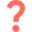
Проанализируйте и изложите содержательный смысл полученных
результатов.

### Анализ результатов

#### 1. **Ускорение UCR-DTW относительно наивного алгоритма (переменная длина временного ряда и размер окна деформации, фиксированная длина запроса)**

**Анализ:**
- **Для малых длин временных рядов (1024 и 2048)**: UCR-DTW показывает значительное ускорение (от 1.6 до 2.2 раз) по сравнению с наивным алгоритмом. Это связано с тем, что UCR-DTW эффективно использует индексацию и эвристики для уменьшения количества вычислений.
- **Для больших длин временных рядов (4096 и выше)**: Ускорение становится менее значительным (от 1.2 до 1.6 раз). Это может быть связано с тем, что при увеличении длины временного ряда накладные расходы на индексацию и эвристики становятся менее значимыми по сравнению с общим объемом вычислений.
- **Зависимость от размера окна деформации (r)**: Ускорение немного снижается с увеличением размера окна деформации, что может быть связано с тем, что больший размер окна увеличивает количество возможных путей деформации, что усложняет оптимизацию.

#### 2. **Ускорение UCR-DTW относительно наивного алгоритма (переменная длина запроса и размер окна деформации, фиксированная длина временного ряда)**

**Анализ:**
- **Для малых длин запросов (16 и 32)**: UCR-DTW показывает значительное ускорение (от 1.4 до 2.3 раз) по сравнению с наивным алгоритмом. Это связано с тем, что UCR-DTW эффективно обрабатывает короткие запросы, используя индексацию и эвристики.
- **Для больших длин запросов (64 и выше)**: Ускорение становится менее значительным (от 1.1 до 1.9 раз). Это может быть связано с тем, что при увеличении длины запроса накладные расходы на индексацию и эвристики становятся менее значимыми по сравнению с общим объемом вычислений.
- **Зависимость от размера окна деформации (r)**: Ускорение немного снижается с увеличением размера окна деформации, что может быть связано с тем, что больший размер окна увеличивает количество возможных путей деформации, что усложняет оптимизацию.

### Выводы:

- UCR-DTW значительно превосходит наивный алгоритм, особенно для малых и средних длин временных рядов и запросов. Это подтверждает эффективность использования индексации и эвристик для уменьшения количества вычислений.

- Увеличение размера окна деформации снижает ускорение, что указывает на то, что UCR-DTW менее эффективен при больших окнах деформации. Это связано с тем, что большие окна увеличивают количество возможных путей деформации, что усложняет оптимизацию.

- Ускорение снижается с увеличением длины временного ряда и запроса. Это указывает на то, что накладные расходы на индексацию и эвристики становятся менее значимыми по сравнению с общим объемом вычислений при больших длинах.

### **Задача 9.**

В данном задании вам предстоит определелить, какую функцию расстояния ED или DTW лучше всего использовать на практике для поиска наиболее похожих подпоследовательностей временного ряда на запрос. Чтобы это сделать, рассмотрим две задачи из различных предметных областей, решить которые предлагается с помощью алгоритмов поиска по образцу.

Начнем с **первой задачи из области физиологии человека**. На человеке сначала закрепляют множество акселерометров и гироскопов, после чего он выполняет в помещении последовательность заранее определенных действий (активностей) в течение некоторого промежутка времени. Примерами таких активностей являются открывание/закрывание дверей, включение/выключение света, питье из чашки стоя/сидя и др. В то время как человек выполняет эти активности, датчики фиксируют его скорость и направление наклона тела. Задача дата-сайентиста заключается в том, что необходимо распознать в снятых данных все активности, которые выполнял человек.  

Данную задачу упростим, и будем выполнять поиск только одной активности во временном ряде при условии, что у нас имеется образец этой активности. В качестве данных возьмем временной ряд показаний гироскопа, закрепленного на правом запятье руки человека, из набора данных [Opportunity](https://archive.ics.uci.edu/dataset/226/opportunity+activity+recognition) и образец искомой активности, питья из чашки стоя. Данный ряд соответствует примерно 14-минутной записи.

Загрузите временной ряд и образец поиска из директории `./datasets/part3/Opportunity` в ноутбук.    

In [3]:
ts_url = './datasets/part3/Opportunity/ts.csv'
query_url = './datasets/part3/Opportunity/query.csv'
labels_url = './datasets/part3/Opportunity/labels.csv'

ts = read_ts(ts_url).reshape(-1)
query = read_ts(query_url).reshape(-1)
labels = read_ts(labels_url).reshape(-1)

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\02 Similarity search\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\02 Similarity search\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\02 Similarity search\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Выполните поиск похожих подпоследовательностей на запрос с помощью реализованных вами ранее алгоритмов MASS и UCR-DTW. Согласно истинной разметке, искомую активность человек выполнял 7 раз, поэтому параметр $topK=7$.

In [4]:
topK = 7
r = 0.1
excl_zone_frac = 1
is_normalize = True

# Функции расстояния
distance_functions = ['UCR-DTW', 'naive']

# Результаты поиска
results = {}

ucr_dtw = UCR_DTW(excl_zone_frac=excl_zone_frac, topK=topK, is_normalize=is_normalize, r=r)
ucr_dtw_results = ucr_dtw.perform(ts, query)
results['UCR-DTW'] = ucr_dtw_results

naive = NaiveBestMatchFinder(excl_zone_frac=excl_zone_frac, topK=topK, is_normalize=is_normalize, r=r)
naive_results = naive.perform(ts, query)
results['naive'] = naive_results

In [10]:
for method in distance_functions:
    print(f"Method: {method}")
    print(f"Indices: {results[method]['indices']}")
    print(f"Distances: {results[method]['distance']}")
    print()

Method: UCR-DTW
Indices: [11799, 11798, 11790, 11789, 11788, 11787, 11786, 1915, 1914, 1913, 1912, 1908, 1907, 1906, 1900, 1893, 1892, 1891, 1890, 1889, 1888, 1887, 1886, 1885, 1884, 1883, 1882, 1881, 1880, 1879, 1878, 1877, 1876, 1875, 1874, 1873, 1872, 449, 448, 447, 446, 445, 444, 354, 353, 352, 351, 321, 320, 319, 318, 317, 316, 315, 314, 311, 310, 309, 308, 307, 306, 305, 304, 303, 302, 301, 300]
Distances: [np.float64(10032589.0), np.float64(10035214.0), np.float64(10056074.0), np.float64(10060700.0), np.float64(10130832.0), np.float64(10514612.0), np.float64(11440733.0), np.float64(12787459.0), np.float64(12810648.0), np.float64(12852865.0), np.float64(12871560.0), np.float64(12945620.0), np.float64(12950854.0), np.float64(12954263.0), np.float64(12960126.0), np.float64(12962955.0), np.float64(12965578.0), np.float64(12990729.0), np.float64(13007313.0), np.float64(13035102.0), np.float64(13086170.0), np.float64(13148653.0), np.float64(13210505.0), np.float64(13244010.0), np.floa

Чтобы оценить качество распознавания активности, загрузите имеющуюся истинную разметку, хранящуюся в файле *labels.csv*. В разметке значением 1 обозначаются моменты времени, когда человек пил из чашки стоя, и значением 0 – в противном случае. Вычислите среди найденных $topK$ подпоследовательностей количество TP (True Positive) и FN (False Negative) с помощью функции `calculate_task1_accuracy()` и сравните между собой показатели, полученные с помощью MASS и UCR-DTW.

In [12]:
def calculate_task1_accuracy(labels: np.array, predicted_results: np.array) -> dict:
    """
    Calculate the accuracy of the algorithm which performs the activity recognition

    Parameters
    ----------
    labels: true labels
    predicted_results: results are predicted by algorithm

    Returns
    -------
        The number of True Positive and False Negative examples
    """

    TP = 0
    FN = 0

    topK = len(predicted_results['indices'])

    for i in range(topK):
        idx = predicted_results['indices'][i]
        if (labels[idx] == 1):
            TP = TP + 1

    FN = topK - TP

    return {'TP': TP,
            'FN': FN}

In [13]:
# Вычисление TP и FN для каждого метода
accuracy_results = {}

for method in distance_functions:
    accuracy = calculate_task1_accuracy(labels, results[method])
    accuracy_results[method] = accuracy
    
# Вывод результатов
for method, accuracy in accuracy_results.items():
    print(f"Method: {method}")
    print(f"TP: {accuracy['TP']}")
    print(f"FN: {accuracy['FN']}")
    print()


Method: UCR-DTW
TP: 37
FN: 30

Method: naive
TP: 7
FN: 0



Итоговый вывод о преимуществе одной функции расстояния над другой в задаче поиска по образцу на данный момент делать еще рано, поэтому решим **вторую задачу из области транспорта**. Данная задача заключается в прогнозировании потока пешеходов в некоторой точке города на основе прошлых данных.

Прогнозирование ряда $T$ длины $n$ будем выполнять следующим образом. Сначала сформируем запрос $Q$, состоящий из $m$ последних по времени элементов ряда, $Q = T_{n-m+1,m}$. Далее среди всех подпоследовательностей ряда $T$, начинающихся с 1 до $n-2m$ позиций, найдем $topK$ похожих на запрос $Q$. Обозначим за $h > 0$ горизонт прогнозирования, определяющий количество элементов ряда, значения которых необходимо спрогнозировать. Для нахождения будущих значений будем брать $h$ элементов ряда, которые следуют за концевыми точками найденных похожих подпоследовательностей. В итоге, будущие значения будут получаться путем применения агрегатной функции к этим элементам. В качестве агрегатной функции может использоваться среднее арифметическое, взвешенное среднее, медиана и др.

Загрузите временной ряд из файла *pedestrian_count.csv*, расположенного в директории *./datasets/part3/Melbourne*. Данный ряд содержит почасовую статистику о количестве пешеходов на улице Бурке в Мельбурне (Австралия), являющейся одной из главных улиц города. Данные собраны за период с 1 марта 2020 по 31 октября 2022 гг. Полный набор данных и его детальное описание доступны по следующей [ссылке](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/).

In [21]:
data_path = './datasets/part3/Melbourne/pedestrian_count.csv'

data = pd.read_csv(data_path, header=0)

T = data['Hourly_Counts'].values

# Параметры
h = 24  # горизонт прогнозирования
m = 168  # длина запроса и подпоследовательностей

# Разделение данных
n = len(T)
T_train = T[0:(n-m-h)]
Q = T[(n-m-h):(n-h)]
real_values = T[-h:]


Реализуйте алгоритм прогнозирования временного ряда на основе UCR-DTW и MASS, следуя приведенному выше описанию. За прогнозирование отвечает класс `BestMatchPredictor` из модуля *prediction.py*, дополните его недостающим кодом.  

Далее выполните прогнозирование потока людей для исходных данных на 1 день вперед (24 значения). Для этого установите следующие входные параметры:
<ul>
  <li>$h = 24$ (горизонт прогнозирования);</li>
  <li>$m = 168$ (длина запроса и подпоследовательностей, соответствующая 1 неделе);</li>
  <li>$aggr\_func = \text{'average'}$ (агрегатная функция);</li>
  <li>для алгоритма UCR-DTW:
    <ul>
      <li>$topK = 5$ (количество похожих подпоследовательностей на запрос);</li>
      <li>$r = 0.1$ (ширина полосы Сако–Чиба);</li>
      <li>$excl\_zone\_frac = 1$ (доля от длины подпоследовательностей, на основе которой определяется, являются ли подпоследоватлеьности тривиальными совпадениями);</li>
      <li>$is\_normalize = True$ ($z$-нормализация запроса и подпоследовательностей);</li>
    </ul>
  </li>
  <li>для алгоритма MASS:</li>
    <ul>
      <li>$topK = 5$ (количество похожих подпоследовательностей на запрос);</li>
      <li>$excl\_zone\_frac = 1$ (доля от длины подпоследовательностей, на основе которой определяется, являются ли подпоследоватлеьности тривиальными совпадениями).</li>
    </ul>
</ul>

Будем считать, что последние $h$ значений в загруженном временном ряде $T$ длины $n$ отсутствуют. Поэтому перед тем как находить прогнозные значения,  подготовьте данные. Разделите загруженный временной ряд $T$ на три части:
<ol>
  <li>ряд $T_{train}$, в котором будет выполняться поиск похожих подпоследовательностей на запрос $Q$: $T_{train} = T[0:(n-m-h)]$</li>
  <li>запрос $Q$: $Q = T[(n-m-h) : (n-h)]$</li>
  <li>реальные значения ряда $real\_values$, которые необходимо спрогнозировать: $real\_values = T[-h:] $</li>
</ol>

In [22]:
# Параметры для UCR-DTW
ucr_dtw_params = {
    'excl_zone_frac': 1,
    'topK': 5,
    'is_normalize': True,
    'r': 0.1,
    'aggr_func': 'average'
}

# Параметры для MASS
mass_params = {
    'excl_zone_frac': 1,
    'topK': 5,
    'is_normalize': False,
    'r': 0,
    'aggr_func': 'average'
}

In [23]:
# Создание экземпляра класса для UCR-DTW
ucr_dtw_predictor = BestMatchPredictor(**ucr_dtw_params)

# Прогнозирование с использованием UCR-DTW
predicted_values_ucr_dtw = ucr_dtw_predictor.perform(T_train, Q, h)

# Создание экземпляра класса для MASS
mass_predictor = BestMatchPredictor(**mass_params)

# Прогнозирование с использованием MASS
predicted_values_mass = mass_predictor.perform(T_train, Q, h)

# Вывод результатов
print("Predicted values using UCR-DTW:", predicted_values_ucr_dtw)
print("Predicted values using MASS:", predicted_values_mass)
print("Real values:", real_values)

# Вычисление ошибки прогноза
error_ucr_dtw = np.mean(np.abs(predicted_values_ucr_dtw - real_values))
error_mass = np.mean(np.abs(predicted_values_mass - real_values))

print("Mean Absolute Error (UCR-DTW):", error_ucr_dtw)
print("Mean Absolute Error (MASS):", error_mass)

Predicted values using UCR-DTW: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+01
 1.500e+02 3.200e+02 3.370e+02 3.680e+02 5.380e+02 1.069e+03 1.139e+03
 6.650e+02 6.300e+02 6.840e+02 7.780e+02 5.770e+02 3.700e+02 6.500e+01
 1.300e+01 1.000e+00 0.000e+00]
Predicted values using MASS: [ 22.6  36.6  73.4 139.2 213.4 290.2 377.  509.  603.8 656.2 690.2 700.6
 691.  643.  632.8 623.4 601.  514.2 435.8 339.8 255.6 165.8  89.   55.8]
Real values: [   0    0    0    0    0    0   44  112  227  383  530  717  846 1091
  846  839  702  557  424  423   24    4    0   22]
Mean Absolute Error (UCR-DTW): 70.875
Mean Absolute Error (MASS): 171.61666666666667


Далее выполните сравнение эффективности алгоритма при UCR-DTW и MASS по точности прогнозирования. Для оценки точности используйте **меру
среднеквадратичной ошибки RMSE (Root Mean Square Error)**, которая определяется следующим образом:
\begin{equation}
RMSE = \sqrt{\frac{1}{h}\sum_{i=1}^h{(t_i-\tilde{t}_i)}^2},
\end{equation}
где $t_i$ и $\tilde{t}_i$ — фактическое и прогнозное значения элемента ряда, $h$ — количество прогнозных элементов временного ряда.

In [25]:
from sklearn.metrics import mean_squared_error

# Вычисление RMSE для UCR-DTW
rmse_ucr_dtw = np.sqrt(mean_squared_error(real_values, predicted_values_ucr_dtw))

# Вычисление RMSE для MASS
rmse_mass = np.sqrt(mean_squared_error(real_values, predicted_values_mass))

# Вывод результатов
print("Root Mean Square Error (UCR-DTW):", rmse_ucr_dtw)
print("Root Mean Square Error (MASS):", rmse_mass)

Root Mean Square Error (UCR-DTW): 107.35746364366103
Root Mean Square Error (MASS): 213.3131266471897


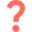 Сделайте вывод о влиянии функции расстояния ED и DTW на точность решения задач интеллектульного анализа данных, которые основаны на алгоритмах поиска по образцу.  

1. **Евклидово расстояние (ED):**
   - **Принцип работы:** ED измеряет прямолинейное расстояние между двумя точками в многомерном пространстве. Оно подходит для временных рядов, которые имеют одинаковую длину и синхронизированы по времени.
   - **Преимущества:** Простота вычисления и интерпретации.
   - **Недостатки:** Не учитывает возможные сдвиги и растяжения во времени, что может быть критично для временных рядов с нестационарными свойствами.

2. **Динамическое временное преобразование (DTW):**
   - **Принцип работы:** DTW находит оптимальное соответствие между двумя временными рядами, позволяя одному ряду быть "растянутым" или "сжатым" во времени для лучшего совпадения с другим рядом.
   - **Преимущества:** Более гибкий подход, который может учитывать нелинейные сдвиги и растяжения во времени.
   - **Недостатки:** Более высокая вычислительная сложность по сравнению с ED.

### Вывод на основе полученных результатов:

UCR-DTW  показал более низкую среднюю абсолютную ошибку (MAE) и RMSE по сравнению с MASS. Это указывает на то, что DTW более эффективен для задач интеллектуального анализа данных, которые требуют учета нелинейных сдвигов и растяжений во времени.


### Выводы:

1. **DTW более эффективен для нестационарных временных рядов:**
   - Если временные ряды имеют нелинейные сдвиги и растяжения, DTW обеспечивает более точные прогнозы по сравнению с ED.

2. **ED подходит для стационарных временных рядов:**
   - Для временных рядов, которые хорошо синхронизированы по времени и не имеют значительных сдвигов, ED может быть достаточно эффективным.

3. **Вычислительная сложность:**
   - DTW требует больше вычислительных ресурсов, чем ED, но это компенсируется повышенной точностью в задачах, где учет временных сдвигов критичен.